##Importing the necessary libraries##

In [ ]:
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from google.colab import drive
drive.mount('/content/gdrive')
import random
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
import random

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def take_input(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        num_blocks = int(lines[0].split('=')[1])

        # Reading adjacency matrix
        adj= np.zeros((num_blocks, num_blocks), dtype=int)
        for i, line in enumerate(lines[2:num_blocks+2]):  # Fix the index here
            if line.strip():  # Check if line is not empty
                adj[i] = list(map(int, line.strip('{}\n').split()))

        # Reading blocks data
        blocks = []
        for line in lines[num_blocks+1:num_blocks*2+3]:  # Fix the index here
            block_info = line.strip('{}\n').split()
            if len(block_info) == 3:
                blocks.append((block_info[0], float(block_info[1]), float(block_info[2]),float(block_info[2])*float(block_info[1])))
                #passing area of the block as well to avoid recalculation.

        # Reading Polish expression
        polish_expression = lines[num_blocks*2+4].strip()  # Fix the index here
        return num_blocks,adj,blocks,polish_expression

In [ ]:
def find_floorplan_area(pe,num_blocks,blocks):
  #print(blocks)
  global area
  curmax=num_blocks
  stack=[]
  for c in pe:
    if c.isdigit():
      stack.append(int(c))
    elif c=='V':
      el1=stack.pop()
      el2=stack.pop()
      el1-=1
      el2-=1
      curht=max(blocks[el1][2],blocks[el2][2])
      curwid=blocks[el2][1]+blocks[el1][1]
      curmax+=1
      blocks.append((curmax, float(curwid), float(curht), float(curwid) * float(curht)))

      stack.append(curmax)
    elif c=='H':
      el1=stack.pop()
      el2=stack.pop()
      el1-=1
      el2-=1
      curwd=max(blocks[el1][1],blocks[el2][1])
      curht=blocks[el2][2]+blocks[el1][2]
      curmax+=1
      blocks.append((curmax, float(curwid), float(curht), float(curwid) * float(curht)))
      stack.append(curmax)
  area=blocks[-1][3]

In [ ]:
def find_plot_limits(blocks):
  global xmax
  xmax=-1
  global ymax
  ymax=-1
  for row in blocks:
    xmax=max(xmax,row[1])#max width
    ymax=max(ymax,row[2])#max height

In [ ]:
def plot_floorplan_area(blocks, polish_expression,num_blocks):
    # Initialize the plot
    curmax=num_blocks
    fig, ax = plt.subplots()
    ax.set_xlim(0, xmax+5)  # Set x-axis limits from 0 to 6
    ax.set_ylim(0,ymax+5)  # Set y-axis limits from 0 to 12
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_title('Floorplan')
    x, y = 0, 0
    stack=[]
    for c in polish_expression:
      if c.isdigit():
        stack.append(int(c))
        c=int(c)
        c-=1
        curwid=blocks[c][1]
        curht=blocks[c][2]
        left_bottom=(x,y)
        rect = Rectangle(left_bottom, curwid, curht, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
      elif c=='H':#horizontal cut.
        el1=stack.pop()
        el2=stack.pop()
        el1-=1
        el2-=1
        curwid=max(blocks[el1][1],blocks[el2][1])
        curht=blocks[el2][2]+blocks[el1][2]
        rect = Rectangle(left_bottom, curwid, curht, linewidth=0, edgecolor='none', facecolor='none', alpha=0)
        x+=curwid
        y+=curht
        curmax+=1
        stack.append(curmax)
      elif c=='V':
        el1=stack.pop()
        el2=stack.pop()
        el1-=1
        el2-=1
        curht=max(blocks[el1][2],blocks[el2][2])
        curwid=blocks[el2][1]+blocks[el1][1]
        rect = Rectangle(left_bottom, curwid, curht, linewidth=0, edgecolor='none', facecolor='none', alpha=0)
        x+=curwid
        y+=curht
        curmax+=1
        stack.append(curmax)
    plt.grid(True)
    plt.show()

In [ ]:
def main():
  file_path="/content/gdrive/MyDrive/test_data.txt"
  num_blocks, adj, blocks, polish_expression =take_input(file_path)
  #print(blocks[1][2])
  find_plot_limits(blocks)
  find_floorplan_area(polish_expression,num_blocks,blocks)
  #print(area) this is the size of the min floorplan.
  plot_floorplan_area(blocks,polish_expression,num_blocks)

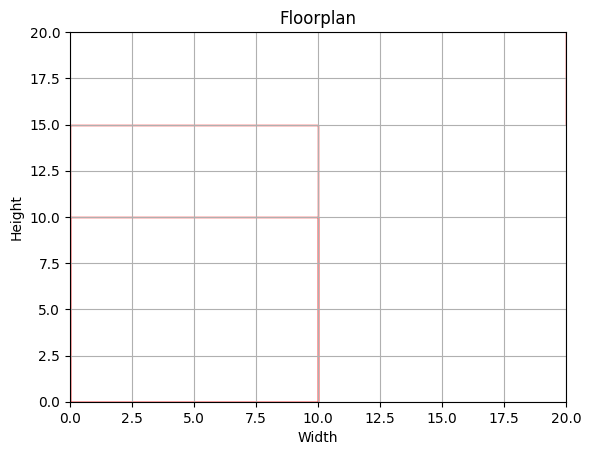

In [ ]:
main()